# 量子ビットのハミルトニアンエミュレーション（簡易版）
最終更新: 2024/03/21 

## ▶ 本資料の説明
本資料は任意なハミルトニアンを持つ量子ビットをエミュレーションするための手法をいくつかまとめている。

[本資料の詳細版](url)

[スライド資料](url)

[ブラウザ版](url)

その他の資料:

[1量子ビットの操作アニメーション](url)

[2量子ビットの操作アニメーション](url)

[マイクロ波のパルス計画](url)


## ▶ セルの構成
**特徴:** 物理レベルのことのみを考慮し設計できる。

セル1: 必要なライブラリのインポート

セル2: 必要な関数の定義

セル3: RXゲートの実行

セル4: RYゲートの実行

セル5: RZゲートの実行

In [122]:
gamma_star_cal(170)

-0.0001495618914414522

In [140]:
def func(x,y, param):
    c,d = param
    return (x+y)*c/10 + d/15

def ff(f,x,y,param):
    return(f(x,y,param))

param = 20,45
ff(func,2,3,param)

13.0

In [138]:
func(2,3,[20,7.5][0])

11.0

In [37]:
# セル1: 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

In [110]:
# セル2: 必要な関数の定義
def factorial(n):
    '''Get the factorial of a integer n.
    Example:    factorial(3) => 6'''
    if ( not(isinstance(n, int)) or (np.sign(n)== -1) ):
        raise Exception('Error: positive integer expected as argument')
    else:
        res = 1
        while (n>1):
            res *= n
            n-= 1
        return res
        
def comb_cal(j):
    '''Calculate the combination in order to solve gamma_cal(j).
    Argument: positive integer j. Returns an array of floats.
    Example:    comb_cal(4) => [1, 6, 11, 6]'''
    if ( not(isinstance(j, int)) or (np.sign(j)== -1) ):
        raise Exception('Error: positive integer expected as argument')
    else:
        if(j == 0):
            return 1
        else:
            k = j
            vec_dict = {}
            while (k != 0):
                vec_dict[k] = np.zeros(k)
                k -= 1
            vec_dict[1][0] = 1
            if (j>1):
                for l in range(2,j+1):
                    for k in range(1,l+1):
                        if(k==1):
                            vec_dict[l][k-1] = 1
                        elif(k==l):
                            vec_dict[l][k-1] = (l-1)*vec_dict[l-1][k-2]
                        else:
                            vec_dict[l][k-1] = vec_dict[l-1][k-1] + (l-1)*vec_dict[l-1][k-2] 
            return vec_dict[j]

def comb_cal2(j):
    '''Calculate the combination in order to solve gamma_star_cal(j).
    Argument: positive integer j. Returns an array of floats.
    Example:    comb_cal2(4) =>  [1, 2, -1, -2, 0]'''
    if ( not(isinstance(j, int)) or (np.sign(j)== -1) ):
        raise Exception('Error: positive integer expected as argument')
    else:
        if(j == 0):
            return 1
        else:
            k = j+1
            vec_dict = {}
            while (k != 0):
                k -= 1
                vec_dict[k] = np.zeros(k+1)
            vec_dict[1][0] = 1
            if (j>0):
                for l in range(0,j+1): #1,2, (3(2+1)
                    for k in range(0,l+1): #0,1...
                        if(k==0):
                            vec_dict[l][k] = 1
                        elif(k==l):
                            if(k==1):
                                vec_dict[l][k] = (l-2)*vec_dict[l][k-1]
                            else:
                                vec_dict[l][k] = 0
                        else:
                            if(l<=1):
                                vec_dict[l][k] = vec_dict[l][k] + (l-2)*vec_dict[l][k-1] 
                            else:    
                                vec_dict[l][k] = vec_dict[l-1][k] + (l-2)*vec_dict[l-1][k-1]       
            return vec_dict[j]

def gamma_cal(j):
    '''Calculate the gamma value for an order j.
    Argument is a positive integer. Returns float.
    Example:    gamma_cal(1) => 0.5
    Limitation: j must be equal or smaller than 170'''
    if ( not(isinstance(j, int)) or (np.sign(j)== -1) ):
        raise Exception('Error: positive integer expected as argument')
    else:
        k = j
        arr = comb_cal(j)
        if (j==0):
            return arr
        gamma = 0
        while(j!=0):
            gamma += arr[k-j]/(j+1)
            j -= 1
        gamma /= factorial(k)
        return gamma

def gamma_star_cal(j):
    '''Calculate the gamma_star value for an order j.
    Argument is a positive integer. Returns float.
    Example:    gamma_star_cal(1) => -0.5
    Limitation: j must be equal or smaller than 170'''
    if ( not(isinstance(j, int)) or (np.sign(j)== -1) ):
        raise Exception('Error: positive integer expected as argument')
    else:
        k = j+1
        arr = comb_cal2(j)
        if (j==0):
            return arr
        gamma_star = 0
        while(k!=0):
            k -= 1
            gamma_star += arr[j-k]/(k+1)
        gamma_star /= factorial(j)
        return gamma_star

def nabla_func(f,X,Y,j,n):
    '''Calculate the nabla value of a function.
    Arguments: function f, function arguments X, Y, order j, number of valid steps n.
    Returns the numerical value in float.'''
    if (j==0):
        return ( f(X[n], Y[n]) ) 
    else:
        if ( hasattr( Y[0], '__len__' ) ):
            nabla = np.zeros(len(Y[0]), dtype="complex")
            for i in range( len(Y[0]) ):
                nabla[i] = nabla_func(f,X,Y,j-1,n)[i] - nabla_func(f,X,Y,j-1,n-1)[i]
            return nabla
        else:
            nabla = nabla_func(f,X,Y,j-1,n) - nabla_func(f,X,Y,j-1,n-1)
            return nabla 

def ddf_adams(Y,X,f,order=5, corr=0):
    '''Calculate the Ordinal Differential Equation of a function with the Adams method, using Differential Division Format.
    Arguments: function f, array of function arguments X, Y, order j, correction steps cs.
    X has to be completely defined.
    Y must have at least one defined value, and the others values may be 0.
    Returns the updated array Y.'''
    
    h = X[1]-X[0] # stepsize
    s = len(X)-1 # number of total steps
    n = 0 # actual step
    k = order # number or previous steps in calculation
    c = corr # number of corrections (ec)
    
    width = 1
    
    # prepare initial multistep
    while (n<k):
        res=nabla_func(f,X,Y,0,n)
        if ( hasattr(y[0], '__len__') ):
            for i in range(len(y[0])):
                Y[n+1][i] = Y[n][i] + h*res[i]
        else:
            Y[n+1] = Y[n] + h*res
        
        #implicit prepare test
        cs=0        
        while(cs<c):
            if ( hasattr(y[0], '__len__') ):
                res = np.zeros(len(y[0]), dtype="complex")
                nabla = nabla_func(f,X,Y,0,n+1)
                for i in range(len(y[0])):
                    res[i] += gamma_star_cal(0) * nabla[i]
                    Y[n+1][i] = Y[n][i] + h*res[i]
                
            else:
                res = 0
                nabla = nabla_func(f,X,Y,0,n+1)
                res += gamma_star_cal(0) * nabla
                Y[n+1] = Y[n] + h*res
            cs += 1        
        n += 1       
        
    # multistep processing
    while (n<s):
        ##prediction
        if ( hasattr(y[0], '__len__') ):
            res = np.zeros(len(y[0]), dtype="complex")
            for j in range(k):
                nabla = nabla_func(f,X,Y,j,n)
                for i in range(len(y[0])):
                    res[i] += gamma_cal(j) * nabla[i]    
            for i in range(len(y[0])):
                Y[n+1][i] = Y[n][i] + h*res[i]
            
        else:
            res = 0
            for j in range(k):
                nabla = nabla_func(f,X,Y,j,n)
                res += gamma_cal(j) * nabla
            Y[n+1] = Y[n] + h*res
        
        ##estimation+correction
        cs=0 # actual correction step
        while(cs<c):
            if ( hasattr(y[0], '__len__') ):
                res = np.zeros(len(y[0]), dtype="complex")
                for j in range(k):
                    nabla = nabla_func(f,X,Y,j,n)
                    for i in range(len(y[0])):
                        res[i] += gamma_cal(j) * nabla[i]    
                for i in range(len(y[0])):
                    Y[n+1][i] = Y[n][i] + h*res[i]   
                    
            else:
                res = 0
                for j in range(k):
                    nabla = nabla_func(f,X,Y,j,n+1)
                res += gamma_star_cal(j) * nabla
                Y[n+1] = Y[n] + h*res
            cs += 1       
        n += 1
        
    return Y


def func(t,psi,):  
    Omega = 50
    omega = 750
    omega_q = 900
    gamma = np.pi
    
    w = Omega*np.sin(2*np.pi*omega*t+gamma)
    H_q = [0,0,0,2*np.pi * omega_q]
    H_d = [0,2*np.pi,2*np.pi,0]
    
    a = (H_q[0] + w*H_d[0])
    b = (H_q[1] + w*H_d[1])
    c = (H_q[2] + w*H_d[2])
    d = (H_q[3] + w*H_d[3])
    
    psi1 = [psi[0]*a + psi[1]*b, psi[0]*c + psi[1]*d] 
    
    psi1[0] = psi1[0]*-1j
    psi1[1] = psi1[1]*-1j
    
    return [psi1[0],psi1[1]]

In [2]:
tlist = np.linspace(0,0.03,1000)

y = [ [0j,0j] for i in range(len(tlist)) ] # 結果を格納するリストをあらかじめ用意しておく

y[0] = [1+0j,0+0j] # 初期値だけ与える

y = ddf_adams(y,tlist,func,order=5, corr=1)

y_0r = np.zeros(len(y))
y_0i = np.zeros(len(y))
y_1r = np.zeros(len(y))
y_1i = np.zeros(len(y))
totalsum = np.zeros(len(y))

for i in range(len(y)):
    y_0r[i] = y[i][0].real
    y_0i[i] = y[i][0].imag
    y_1r[i] = y[i][1].real
    y_1i[i] = y[i][1].imag
    totalsum[i] = abs(y[i][0]**2) + abs(y[i][1]**2)

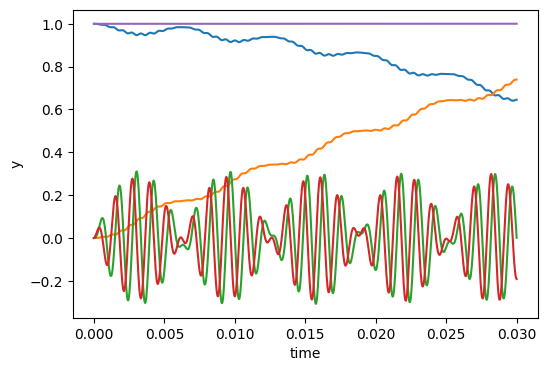

In [3]:
plt.rcParams['figure.figsize'] = [6, 4]

plt.plot(tlist, y_0r)
plt.plot(tlist, y_0i)
plt.plot(tlist, y_1r)
plt.plot(tlist, y_1i)
plt.plot(tlist, totalsum)
  
# Legend

plt.xlabel('time')
plt.ylabel('y')

plt.show()

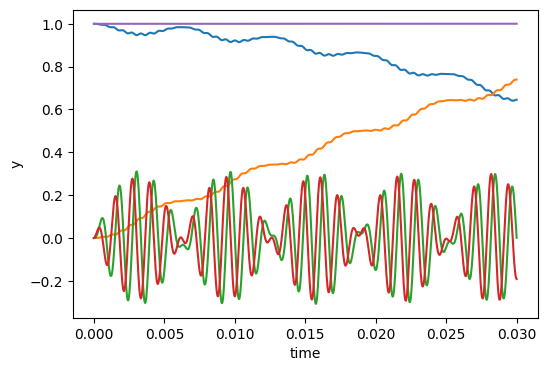

In [4]:
plt.rcParams['figure.figsize'] = [6, 4]

plt.plot(tlist, y_0r)
plt.plot(tlist, y_0i)
plt.plot(tlist, y_1r)
plt.plot(tlist, y_1i)
plt.plot(tlist, totalsum)
  
plt.xlabel('time')
plt.ylabel('y')

plt.show()